# Loading the MNIST dataset in Keras

The dataset is downloaded automatically the first time this function is called and is stored in your home directory in ~/.keras/datasets/mnist.pkl.gz as a 15MB file.

To demonstrate how easy it is to load the MNIST dataset, we will first write a little script to download and visualize the first 4 images in the training dataset.

(60000, 28, 28)


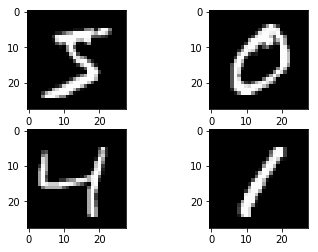

In [3]:
# Plot ad hoc mnist instances
from keras.datasets import mnist
import matplotlib.pyplot as plt
# load dataset
(X_train,y_train),(X_test, y_test)=mnist.load_data()
print(X_train.shape)
#print(X_train[1])
# plot 4 images as gray scale
plt.show()
plt.subplot(221)
plt.imshow(X_train[0],cmap=plt.get_cmap('gray'))
plt.subplot(222)
plt.imshow(X_train[1],cmap=plt.get_cmap('gray'))
plt.subplot(223)
plt.imshow(X_train[2],cmap=plt.get_cmap('gray'))
plt.subplot(224)
plt.imshow(X_train[3],cmap=plt.get_cmap('gray'))
# show the plot
plt.show()

# Baseline Model with Multi-Layer Perceptron

In [12]:
# Baseline model
import numpy
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.utils import np_utils
# fix random seed for reproducibility
seed=7
numpy.random.seed(seed)
# load data
(X_train,y_train),(X_test, y_test)=mnist.load_data()
print(X_train.shape)
# The training dataset is structured as a 3-dimensional array of instance, 
# image width and image height. For a multi-layer perceptron model we must 
# reduce the images down into a vector of pixels. 
# In this case the 28×28 sized images will be 784 pixel input values.

# We can do this transform easily using the reshape() function on the NumPy array. 
# We can also reduce our memory requirements by forcing the precision of the pixel values to be 32 bit,
# the default precision used by Keras anyway.

# flatten 28*28 images to a 784 vector for each image
num_pixels=X_train.shape[1] * X_train.shape[2]
X_train=X_train.reshape(X_train.shape[0],num_pixels).astype('float32')
X_test=X_test.reshape(X_test.shape[0],num_pixels).astype('float32')

# The pixel values are gray scale between 0 and 255. It is almost always 
# a good idea to perform some scaling of input values when using neural network models. 
# Because the scale is well known and well behaved, we can very quickly normalize the pixel values 
# to the range 0 and 1 by dividing each value by the maximum of 255.

# normalize inputs from 0-255 to 0-1
X_train=X_train / 255
X_test= X_test /255

# Finally, the output variable is an integer from 0 to 9. 
# This is a multi-class classification problem. As such, 
# it is good practice to use a one hot encoding of the class values, 
# transforming the vector of class integers into a binary matrix.

# one-hot encoded outputs
y_train=np_utils.to_categorical(y_train)
y_test=np_utils.to_categorical(y_test)
num_classes=y_test.shape[1]

# define a baseline model
def baseline_model():
        # create model
        model=Sequential()
        model.add(Dense(num_pixels, input_dim=num_pixels, kernel_initializer='normal', activation='relu'))
        model.add(Dense(num_classes, kernel_initializer='normal', activation='softmax'))
        # compile model
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        return model
    
# A softmax activation function is used on the output layer to turn the outputs into probability-like values and 
# allow one class of the 10 to be selected as the model’s output prediction.

# build the model
model=baseline_model()
model.fit(X_train,y_train, validation_data=(X_test,y_test),epochs=10, batch_size=200, verbose=2)
# final evaluation of the model
scores=model.evaluate(X_test,y_test,verbose=0)
print("Baseline Error: %.2f%%" %(100-scores[1]*100))

(60000, 28, 28)
Train on 60000 samples, validate on 10000 samples
Epoch 1/10
 - 6s - loss: 0.0464 - acc: 0.9844 - val_loss: 0.0244 - val_acc: 0.9919
Epoch 2/10
 - 5s - loss: 0.0197 - acc: 0.9937 - val_loss: 0.0167 - val_acc: 0.9942
Epoch 3/10
 - 5s - loss: 0.0130 - acc: 0.9959 - val_loss: 0.0137 - val_acc: 0.9956
Epoch 4/10
 - 5s - loss: 0.0092 - acc: 0.9972 - val_loss: 0.0130 - val_acc: 0.9956
Epoch 5/10
 - 7s - loss: 0.0070 - acc: 0.9979 - val_loss: 0.0122 - val_acc: 0.9960
Epoch 6/10
 - 6s - loss: 0.0051 - acc: 0.9985 - val_loss: 0.0113 - val_acc: 0.9961
Epoch 7/10
 - 6s - loss: 0.0040 - acc: 0.9989 - val_loss: 0.0112 - val_acc: 0.9964
Epoch 8/10
 - 6s - loss: 0.0028 - acc: 0.9993 - val_loss: 0.0112 - val_acc: 0.9962
Epoch 9/10
 - 6s - loss: 0.0022 - acc: 0.9995 - val_loss: 0.0105 - val_acc: 0.9963
Epoch 10/10
 - 5s - loss: 0.0016 - acc: 0.9997 - val_loss: 0.0110 - val_acc: 0.9962
Baseline Error: 0.38%


# Simple Convolutional Neural Network for MNIST

In this section we will create a simple CNN for MNIST that demonstrates how to use all of the aspects of a modern CNN implementation, including Convolutional layers, Pooling layers and Dropout layers.

In [14]:
# Simple CNN model
import numpy
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
K.set_image_dim_ordering('th')
# fix random seed for reproducibility
seed=7
numpy.random.seed(seed)

# We need to load the MNIST dataset and reshape it so that it is suitable for use training a CNN. 
# In Keras, the layers used for two-dimensional convolutions expect pixel values 
# with the dimensions [pixels][width][height].

# In the case of RGB, the first dimension pixels would be 3 for the red, green and blue components 
# and it would be like having 3 image inputs for every color image. 
# In the case of MNIST where the pixel values are gray scale, the pixel dimension is set to 1.

# load data
(X_train,y_train),(X_test, y_test)=mnist.load_data()
# reshape to be [samples][pixels][width][height]
X_train=X_train.reshape(X_train.shape[0],1,28,28).astype('float32')
X_test=X_test.reshape(X_test.shape[0],1,28,28).astype('float32')
print(X_train.shape)

# normalize inputs from 0-255 to 0-1
X_train=X_train / 255
X_test= X_test /255
# one hot encode outputs
y_train=np_utils.to_categorical(y_train)
y_test=np_utils.to_categorical(y_test)
num_classes=y_test.shape[1]

# define a simple cnn model
def baseline_model():
    # create model
    model=Sequential()
    model.add(Conv2D(32,(5,5), input_shape=(1,28,28),activation='relu')) # first hidden layer with 
                                                                        # 32 feature maps with size 5*5
    model.add(MaxPooling2D(pool_size=(2,2))) # pooling layer with a pool size of 2*2
    model.add(Dropout(0.2))   # regularization layer with randomly exclude 20%
    model.add(Flatten())   # a layer that converts the 2D matrix data to a vector called Flatten. 
                          #It allows the output to be processed by standard fully connected layers.
    model.add(Dense(128,activation='relu')) # a fully connected layer with 128 neurons
    model.add(Dense(num_classes,activation='softmax')) # the output layer has 10 neurons for the 10 classes
    # compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# build the model
model=baseline_model()
# fit the model
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=200,verbose=2)
# final evaluation of the model
scores=model.evaluate(X_test,y_test,verbose=0)
print("CNN Error: %.2f%%" %(100-scores[1]*100))    

(60000, 1, 28, 28)
Train on 60000 samples, validate on 10000 samples
Epoch 1/10
 - 191s - loss: 0.2253 - acc: 0.9357 - val_loss: 0.0802 - val_acc: 0.9749
Epoch 2/10
 - 187s - loss: 0.0725 - acc: 0.9782 - val_loss: 0.0451 - val_acc: 0.9845
Epoch 3/10


KeyboardInterrupt: 

# Larger Convolutional Neural Network for MNIST

In [ ]:
# Larger CNN for the MNIST Dataset
import numpy
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
K.set_image_dim_ordering('th')
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)
# load data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# reshape to be [samples][pixels][width][height]
X_train = X_train.reshape(X_train.shape[0], 1, 28, 28).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28).astype('float32')
# normalize inputs from 0-255 to 0-1
X_train = X_train / 255
X_test = X_test / 255
# one hot encode outputs
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

# define the larger CNN model
def larger_model():
    # create model
    model=Sequential()
    model.add(Conv2D(30,(5,5), input_shape=(1,28,28),activation='relu')) # first hidden layer with 
                                                                        # 30 feature maps with size 5*5
    model.add(MaxPooling2D(pool_size=(2,2))) # pooling layer with a pool size of 2*2
    model.add(Conv2D(15,(3,3), input_shape=(1,28,28),activation='relu')) # hidden layer with 
                                                                        # 15 feature maps with size 3*3
    model.add(MaxPooling2D(pool_size=(2,2))) # pooling layer with a pool size of 2*2    
    model.add(Dropout(0.2))   # regularization layer with randomly exclude 20%
    model.add(Flatten())   # a layer that converts the 2D matrix data to a vector called Flatten. 
                          #It allows the output to be processed by standard fully connected layers.
    model.add(Dense(128,activation='relu')) # a fully connected layer with 128 neurons
    model.add(Dense(50,activation='relu')) # a fully connected layer with 50 neurons
    model.add(Dense(num_classes,activation='softmax')) # the output layer has 10 neurons for the 10 classes
    # compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model    

# build the model
model=larger_model()
# fit the model
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=200,verbose=2)
# final evaluation of the model
scores=model.evaluate(X_test,y_test,verbose=0)
print("Larger CNN Error: %.2f%%" %(100-scores[1]*100))   